# This notebook has for objective to cluster images based on visual similarities
The final goal is to identify differents types of spectrograms in order to design a recognition model to detect u shapes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle



## Collect spectrograms

In [ ]:
path = r"/content/drive/MyDrive/HARP_DATASET/1_day_image/square_images_size224"
os.chdir(path)

spectrograms = []

with os.scandir(path) as files:
    for file in files:
        if file.name.endswith('.png'):
            spectrograms.append(file.name)

print(len(spectrograms))

3269


# Data preprocessing
We should change the size by 224 to fit with the model

In [ ]:
img = load_img(spectrograms[0], target_size=(224,224))
img = np.array(img)

print(img.shape)
(224, 224, 3)

(224, 224, 3)


(224, 224, 3)

# Adding dimension

In [ ]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [ ]:
x = preprocess_input(reshaped_img)

# Model
Loading the VGG16 model for transfer learning

In [1]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

NameError: ignored

## Definition of extract function
This function has for objectives to predict features with the VGG16 model

In [ ]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

## Extrating features in a dictionary

In [ ]:
data = {}
p = r"/content/drive/MyDrive/spectograms_features.pk1"

# lop through each image in the dataset
for spectrogram in spectrograms:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(spectrogram,model)
        data[spectrogram] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)

# # get the unique labels (from the flower_labels.csv)
# df = pd.read_csv('flower_labels.csv')
# label = df['label'].tolist()
# unique_labels = list(set(label))

(210, 4096)

## Using PCA and cluster creation
On this example we have 6 clusters

In [ ]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# cluster feature vectors
kmeans = KMeans(n_clusters=4, random_state=22)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster, n_pictures=30):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to n_pictures images to be shown at a time
    if len(files) > n_pictures:
        print(f"Clipping cluster size from {len(files)} to {n_pictures}")
        files = files[:(n_pictures-1)]
    # plot each image in the cluster
    print("Cluster " + str(cluster) + " ------------------------------------------------------------------------------------------------------------------------------------------------------------------- ")  
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')



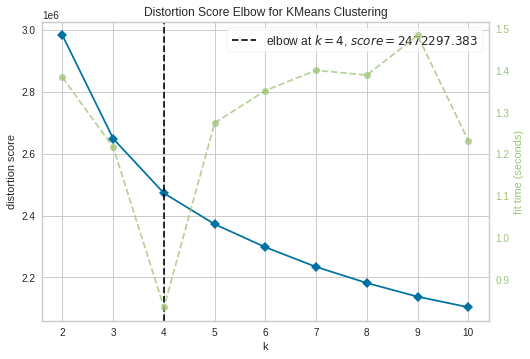

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
model = KElbowVisualizer(KMeans(), k=10)

model.fit(x)

model.show()


### Cluster 1
Seems to represent the non processed images

Clipping cluster size from 1488 to 50
Cluster 0 ------------------------------------------------------------------------------------------------------------------------------------------------------------------- 


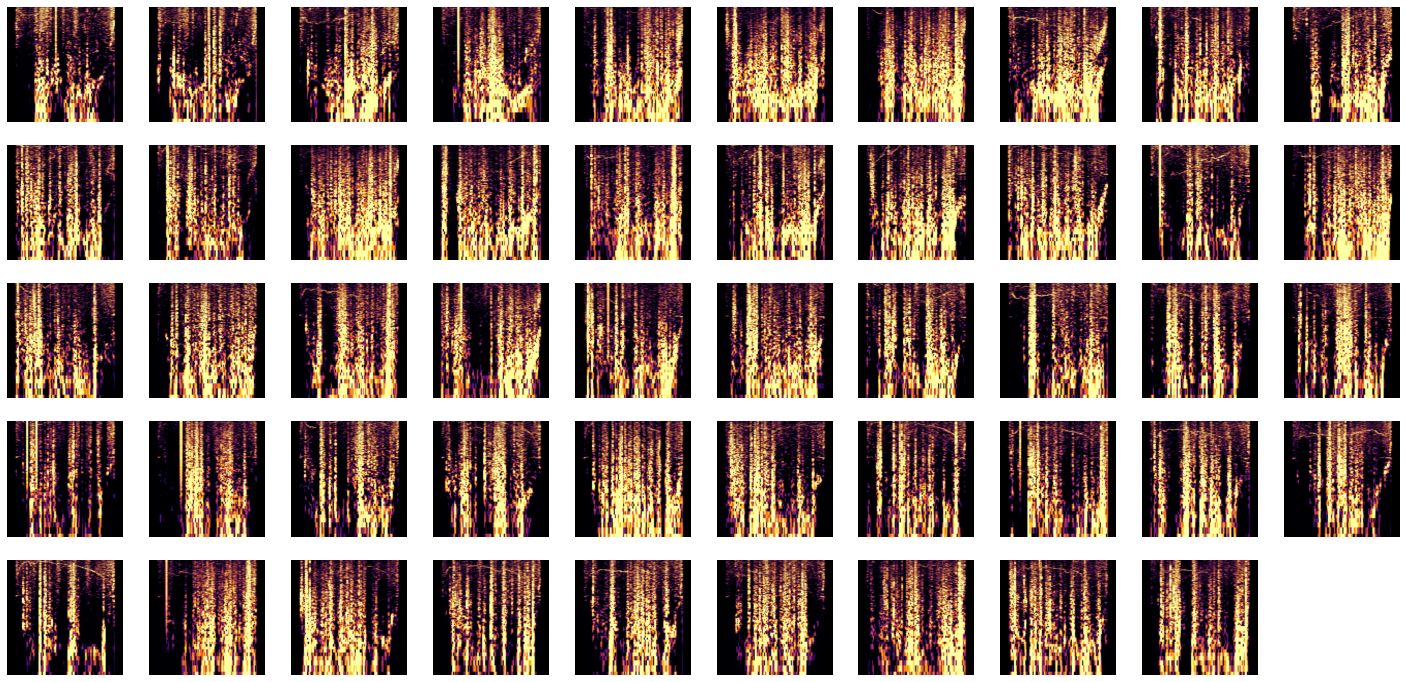

In [ ]:
view_cluster(0,50)


### Cluster 2
Seems to represent little noisy spectrograms

Clipping cluster size from 415 to 50
Cluster 1 ------------------------------------------------------------------------------------------------------------------------------------------------------------------- 


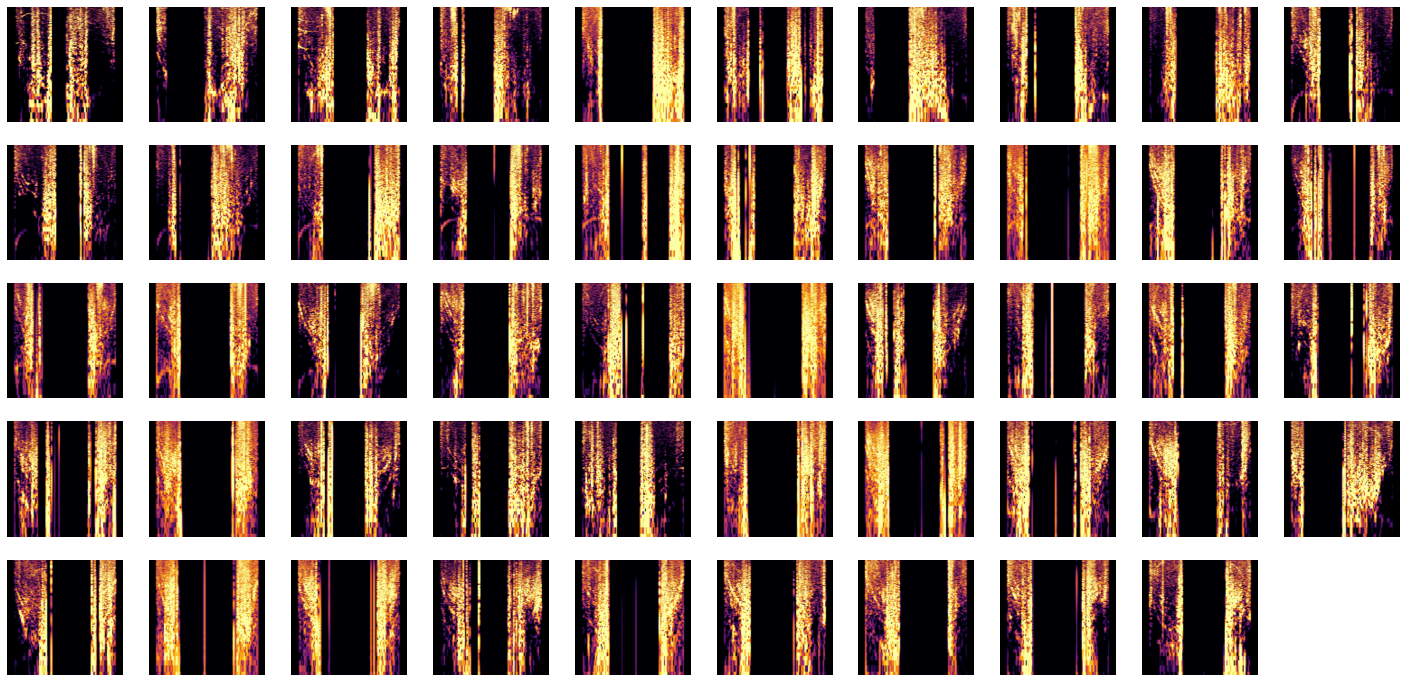

In [ ]:
view_cluster(1,50)


### Cluster 3
Seems to represent clearest spectrograns

Clipping cluster size from 118 to 50
Cluster 2 ------------------------------------------------------------------------------------------------------------------------------------------------------------------- 


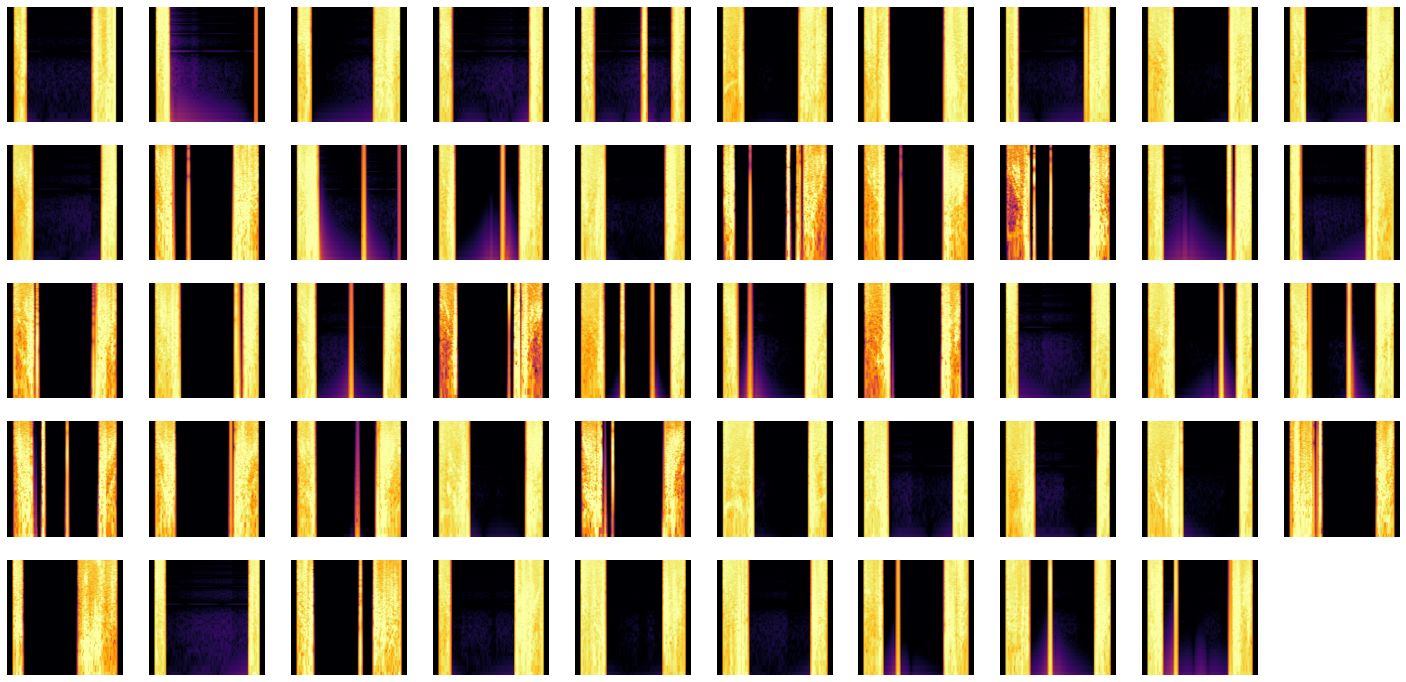

In [ ]:

view_cluster(2,50)   

### Cluster 4
Other noisy spectrograms but we can clearly see U shape

Clipping cluster size from 1248 to 50
Cluster 3 ------------------------------------------------------------------------------------------------------------------------------------------------------------------- 


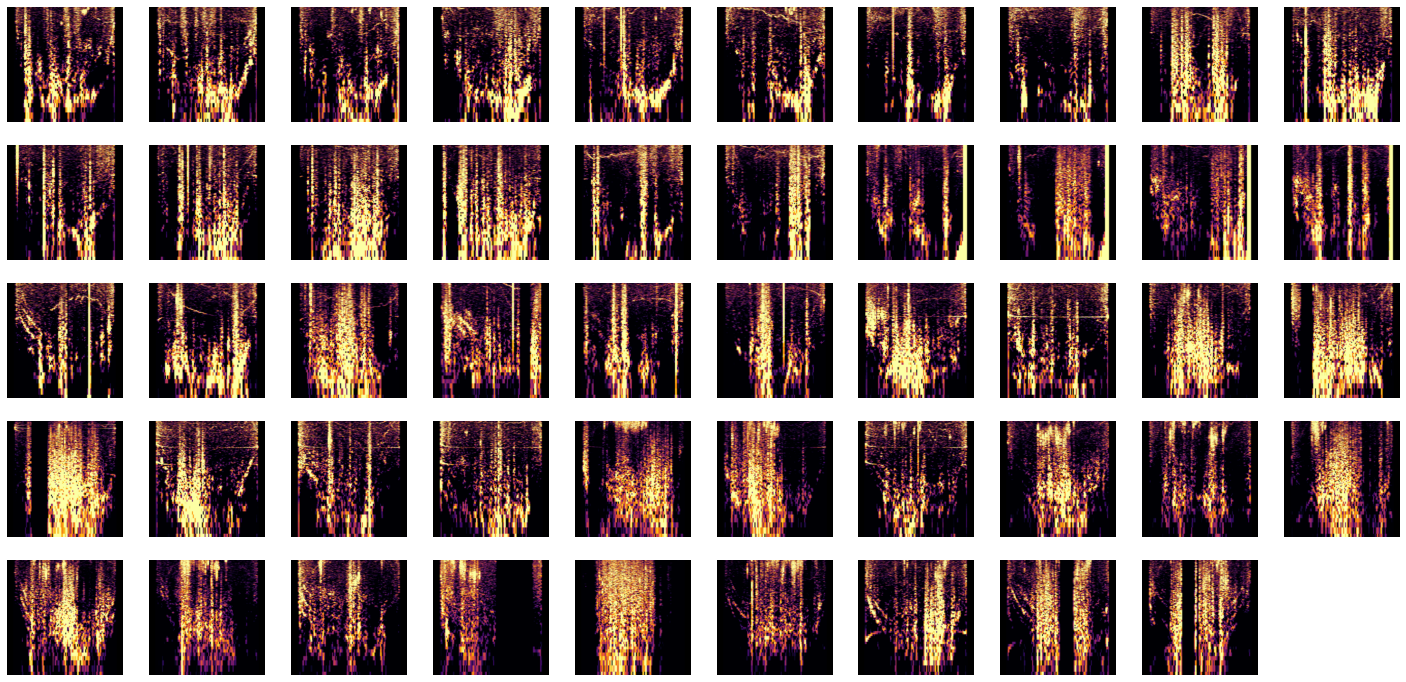

In [ ]:
view_cluster(3,50)

### Cluster 5
Noisy spectrograms but, without U shape

In [ ]:
view_cluster(4,50)

KeyError: ignored

<Figure size 1800x1800 with 0 Axes>

### Cluster 6
Like the first cluster but sometimes U shapes appear

In [ ]:
view_cluster(5,50)

KeyError: ignored

<Figure size 1800x1800 with 0 Axes>

In [ ]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(x)
    kmeanModel.fit(x)
  
    distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / x.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(x, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / x.shape[0]
    mapping2[k] = kmeanModel.inertia_

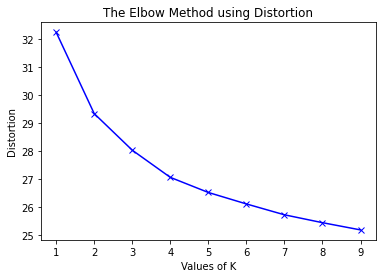

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

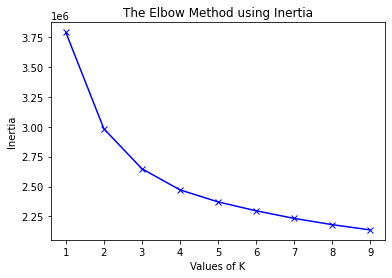

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()